# Compare single step prediction between

* FVT = Model with Finite volume averaging in vertical, and log-transformed humidity
* Baseline = basically p0, but select vertical levels closest to the centers of FVT levels, and keep humidity as we have done before

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import jax

from graphufs.datasets import Dataset
from graphufs.batchloader import BatchLoader

from graphufs.utils import get_last_input_mapping

from config import TP0Emulator
from baseline import P0Emulator

/home/tsmith/work/graph-ufs/graphufs/training.py:59: UserWarning: Import failed for either mpi4py or mpi4jax.
  warnings.warn("Import failed for either mpi4py or mpi4jax.")


In [2]:
from weatherbench2.derived_variables import ZonalEnergySpectrum

In [3]:
import graphufs
plt.style.use("graphufs.plotstyle")

In [4]:
from functools import partial
import haiku as hk

from graphcast import rollout

from graphufs import construct_wrapped_graphcast
from graphufs.inference import swap_batch_time_dims

In [5]:
def predict(
    emulator,
    dataset,
    idx=0,
    ckpt_id=49,
) -> xr.Dataset:

    params, state = emulator.load_checkpoint(id=ckpt_id)

    @hk.transform_with_state
    def run_forward(inputs, targets_template, forcings):
        predictor = construct_wrapped_graphcast(emulator)
        return predictor(inputs, targets_template=targets_template, forcings=forcings)

    def with_params(fn):
        return partial(fn, params=params, state=state)

    def drop_state(fn):
        return lambda **kw: fn(**kw)[0]

    gc = drop_state(with_params(jax.jit(run_forward.apply)))

    inputs, targets, forcings = dataset.get_xarrays(idx)
    inputs.load()
    targets.load()
    forcings.load()

    # retrieve and drop t0
    inittimes = inputs.datetime.isel(time=-1).values
    inputs = inputs.drop_vars("datetime")
    targets = targets.drop_vars("datetime")
    forcings = forcings.drop_vars("datetime")

    predictions = rollout.chunked_prediction(
        gc,
        rng=jax.random.PRNGKey(0),
        inputs=inputs,
        targets_template=np.nan * targets,
        forcings=forcings,
    )

    # Add t0 as new variable, and swap out for logical sample/batch index
    predictions = swap_batch_time_dims(predictions, inittimes)
    targets = swap_batch_time_dims(targets, inittimes)

    return predictions, targets

In [6]:
fvt = TP0Emulator()

In [7]:
p0 = P0Emulator()

In [8]:
fvds = Dataset(fvt, mode="validation")
pds = Dataset(p0, mode="validation")

In [9]:
predictions = {}
targets = {}
for em, ds, label in zip(
    [fvt, p0],
    [fvds, pds],
    ["FVT", "Baseline"],
):
    predictions[label], targets[label] = predict(
        emulator=em,
        dataset=ds,
    )

In [10]:
varlist = ["tmp", "spfh", "tmp2m", "spfh2m"]

### Snapshots

In [13]:
tkw = lambda ax: dict(ha="left", va="center", backgroundcolor="white", transform=ax.transAxes)

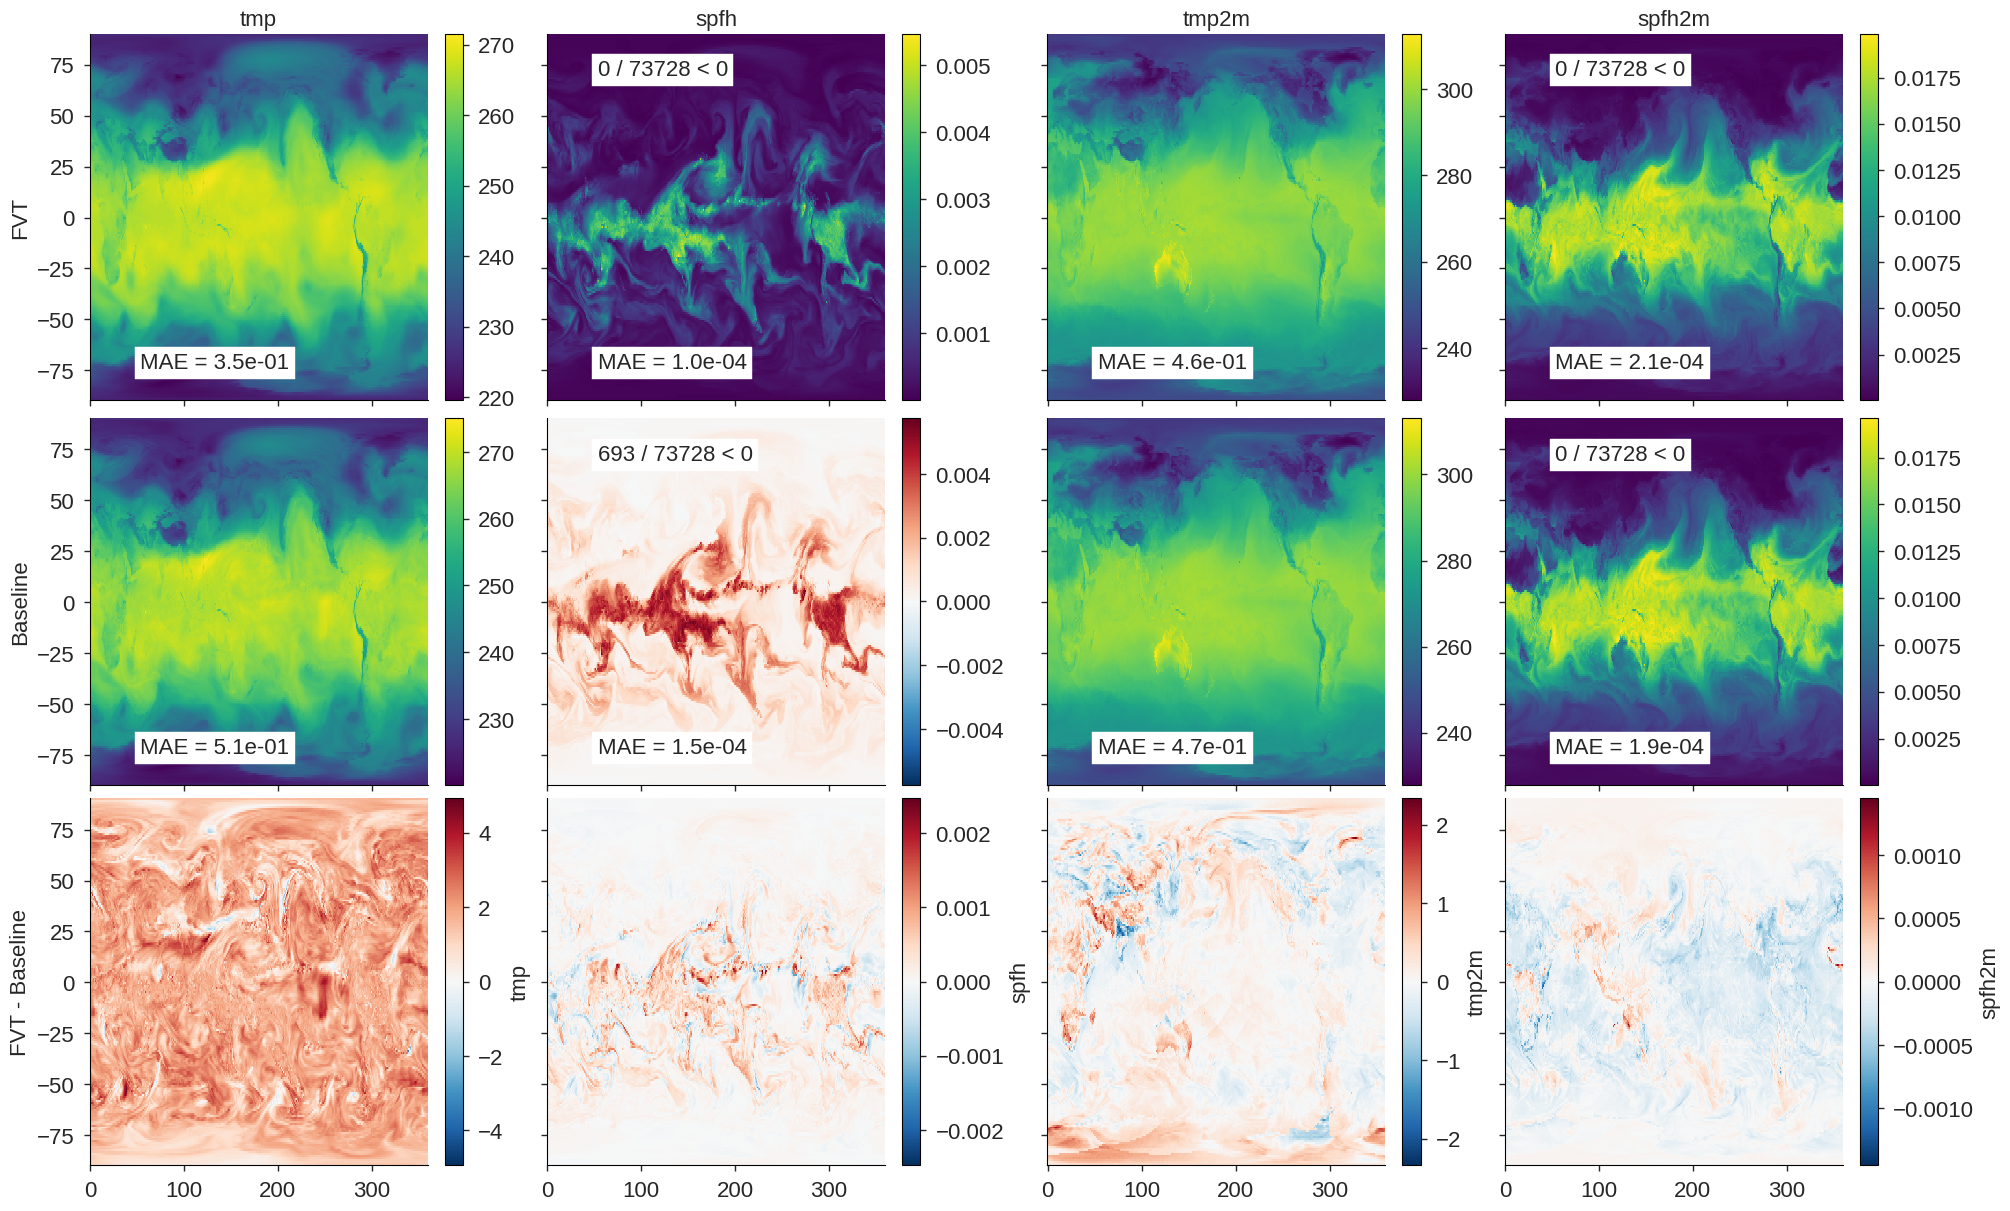

In [14]:
nrows = 3
ncols = len(varlist)
fig, axs = plt.subplots(nrows, len(varlist), figsize=(ncols*5, nrows*4), constrained_layout=True, sharex=True, sharey=True)

ilevel = 0
index = 10

plotlist = {k : list() for k in varlist}
for (key, pred), axr in zip(predictions.items(), axs):
    
    for v, ax in zip(varlist, axr):
        plotme = pred[v].squeeze()
        target = targets[key][v].squeeze()
        if "level" in plotme.dims:
            plotme = plotme.isel(level=ilevel, drop=True)
            target = target.isel(level=ilevel, drop=True)
            

        if "FV" in key:
            if v in fvt.output_transforms:
                plotme = fvt.output_transforms[v](plotme)
                target = fvt.output_transforms[v](target)
        plotlist[v].append(plotme)
        mae = np.abs(plotme - target).mean().values
        plotme.plot(ax=ax, cbar_kwargs={"label": ""})
        ax.set(
            xlabel="",
            ylabel=key if ax.get_subplotspec().is_first_col() else "",
            title=v if ax.get_subplotspec().is_first_row() else "",
        )
        ax.text(.15, .1, f"MAE = {mae:1.1e}", **tkw(ax))
        if "spfh" in v:
            ngz = (plotme<0).sum().values
            tot = int(len(plotme.lat) * len(plotme.lon))
            ax.text(.15, .9, f"{ngz} / {tot} < 0", **tkw(ax))
for v, ax in zip(varlist, axs[-1]):
    diff = plotlist[v][1] - plotlist[v][0]
    diff.plot(ax=ax)
    ax.set(
        xlabel="",
        ylabel="FVT - Baseline" if ax.get_subplotspec().is_first_col() else "",
        title="",
    )

### Spectra

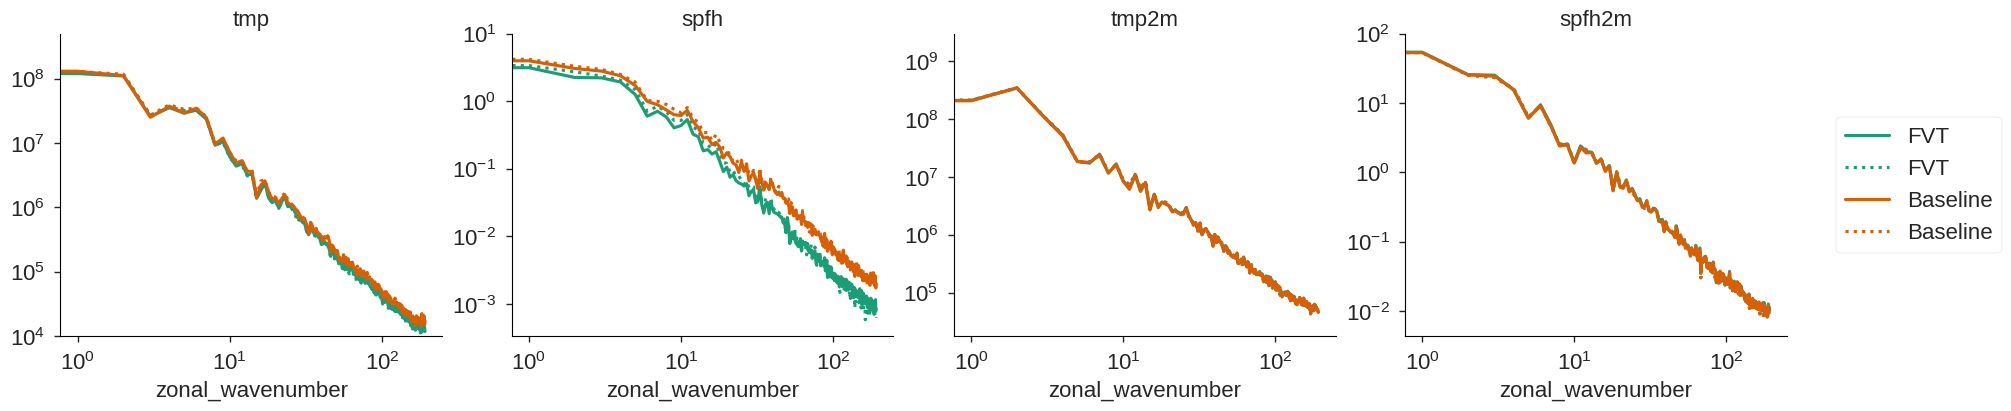

In [15]:
ncols = len(varlist)
fig, axs = plt.subplots(1, len(varlist), figsize=(ncols*5, 4), constrained_layout=True, sharex=True)

ilevel = 0
index = 10

plotlist = {k : list() for k in varlist}
for cid, (key, pred) in enumerate(predictions.items()):
    
    for v, ax in zip(varlist, axs):
        computer = ZonalEnergySpectrum(v)
        for xds, ls in zip([pred, targets[key]], ["-", ":"]):
            plotme = xds[[v]].squeeze()
            plotme = plotme.rename({"lat": "latitude", "lon": "longitude"})
            if "level" in plotme.dims:
                plotme = plotme.isel(level=ilevel, drop=True)
            if key == "FVT":
                if v in fvt.output_transforms:
                    plotme = fvt.output_transforms[v](plotme)

            plotme = plotme.compute()
            plotme = computer.compute(plotme)
            plotme = plotme.mean("latitude")
            plotlist[v].append(plotme)
            plotme.plot(ax=ax, xscale="log", yscale="log", x="zonal_wavenumber", linestyle=ls, color=f"C{cid}", label=key)
        ax.set(title=v)
axs[0].set(ylim=(1e4, 5e8))
axs[1].set(ylim=(None, 1e1))
axs[2].set(ylim=(None, 3e9))
axs[3].set(ylim=(None, 1e2))
axs[3].legend(bbox_to_anchor=(1.1, .5), loc="center left")